In [1]:
def cutoff_youdens_j_index(fpr, tpr):
    j_scores = tpr-fpr # J = sensivity + specificity - 1
    indices = range(tpr.size)
    j_ordered = sorted(zip(j_scores, indices))
    return j_ordered[-1][1]


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

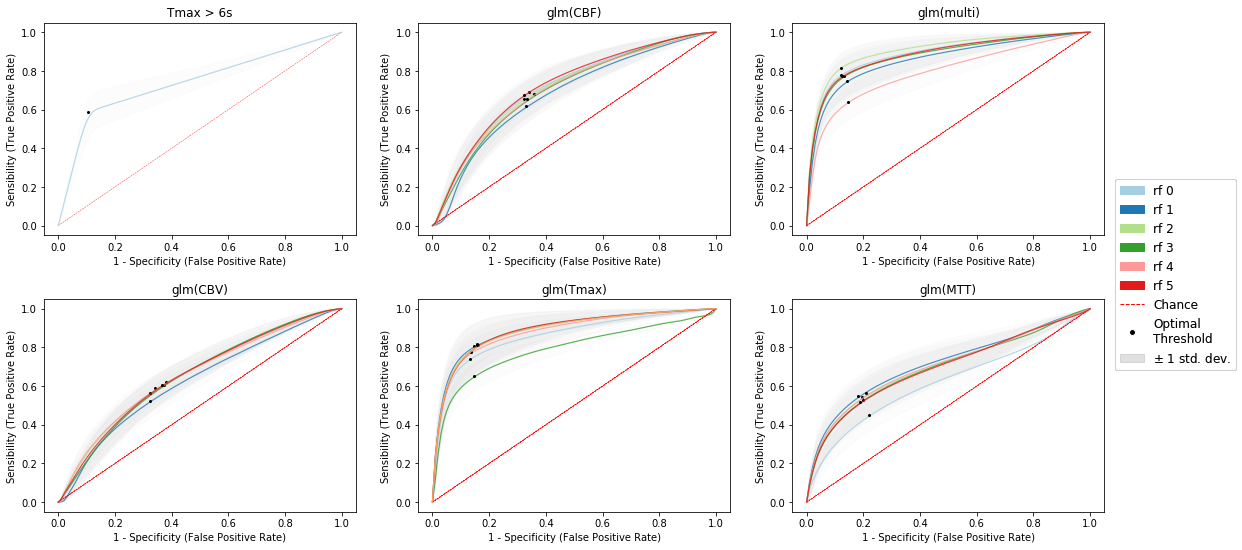

In [104]:
import os, torch
import pandas as pd
import numpy as np
import seaborn as sns
from plot_ROC import plot_roc
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Plot a ROC for every rf for every model 

def ROC_perModel(modality_dir, save_dir = None, n_models = 0, max_rf = 6):
    if save_dir is None: save_dir = modality_dir
    plt.switch_backend('agg')
    ncol = 3
    nrow = 2 
    figure = plt.figure(figsize=(6*ncol+1, 4*nrow+1))
    gs = gridspec.GridSpec(nrow, ncol, hspace=0.3)
    
    models = [o for o in os.listdir(modality_dir)
                    if os.path.isdir(os.path.join(modality_dir,o))]
    if not n_models:
        n_models = len(models)
    m_index = 0
    for model in models[0:]:
        model_dir = os.path.join(modality_dir, model)
        evals = [o for o in os.listdir(model_dir)
                        if os.path.isdir(os.path.join(model_dir,o))]
        
        model_name = model
        if model == 'CBF1_logRegGLM':
            model_name = 'glm(CBF)'
        if model == 'CBV3_logRegGLM':
            model_name = 'glm(CBV)'
        if model == 'MTT2_logRegGLM':
            model_name = 'glm(MTT)'
        if model == 'multi_modal_LogRegGLM':
            model_name = 'glm(multi)'
        if model == 'Tmax0_logRegGLM':
            model_name = 'glm(Tmax)'
        if model == 'Unscaled_customTresholdTmax0':
            continue
        if model == 'Unscaled_Tmax0_6_Treshhold':
            model_name = 'Tmax > 6s'      
            
        rf_index = 0
        for eval_dir in evals[0:]:
            files = os.listdir(os.path.join(model_dir, eval_dir))
            for file in files:
                if (file.startswith('scores_') and file.endswith('.npy')):
                    score_path = os.path.join(model_dir, eval_dir, file)
                    scores = torch.load(score_path)

                    # In older versions params were not seperated
                    param_obj = scores
                    if 'params' in scores:
                        param_obj = scores['params']
                    try:
                        rf = np.median(param_obj['rf'])
                    except KeyError:
                        rf = int(file.split('_')[-1].split('.')[0])
                    
                    FPRS = scores['test_FPR']
                    TPRS = scores['test_TPR']
                    
                    i_line =(m_index // gs.get_geometry()[1])
                    i_row = m_index % gs.get_geometry()[1]

                    # plot ROC image
                    ax = plt.subplot(gs[i_line, i_row])
                    plot_roc(TPRS, FPRS, model_name = model_name, 
                             line_color=sns.color_palette("Paired")[rf_index], std_intensity = 0.02)
                    
                    # plot optimal threshold point
                    j_indeces = [cutoff_youdens_j_index(FPRS[round], TPRS[round]) for round in range(len(TPRS))]
                    median_best_TPR = np.mean([TPRS[round][j] for round, j in enumerate(j_indeces)])
                    median_best_FPR = np.mean([FPRS[round][j] for round, j in enumerate(j_indeces)])
                    plt.plot([median_best_FPR], [median_best_TPR], marker='o', markersize=2, color="black")

                    ax.get_legend().remove()
            rf_index += 1
        m_index += 1

        legend_elements = []
        for rf in range(max_rf):
            rf_patch = mpatches.Patch(color=sns.color_palette("Paired")[rf], label='rf ' + str(rf))
            legend_elements.append(rf_patch)
            
        legend_elements.append(Line2D([0], [0], color='r', lw=1, linestyle='--', label='Chance'))
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Optimal\nThreshold',
                          markerfacecolor='black', markersize=6))
        legend_elements.append(mpatches.Patch(color='grey', alpha=0.2, label=r'$\pm$ 1 std. dev.'))
            
        plt.figlegend(handles=legend_elements, loc = 'right', fontsize = 'large')
    
        fig1 = plt.gcf()
        plt.show()
        fig1.savefig(os.path.join(save_dir, 'compare_ROC_per_model.svg'), bbox_inches='tight', format="svg")
                
                
dir = '/Users/julian/stroke_research/pilotBatch_2016_results/server_output/selected_for_article1_13022019/'
ROC_perModel(dir, n_models = 6)


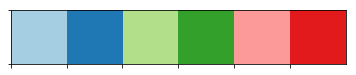

In [66]:
sns.palplot(sns.color_palette("Paired")[0:6])
